In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ephyspy.sweeps import EphysSweepSet, EphysSweep  # Custom class for handling sweeps
from ephyspy.features import *  # available spike, sweep and sweepset level features
from ephyspy.utils import get_feature
from ephyspy.analysis import plot_sweepset_diagnostics, plot_spike_features


import jupyter_black
import time

jupyter_black.load()

In [2]:
def timeit(func, msg):
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"{msg}: {end-start:.4f} s")

    return wrapper

## load data

In [3]:
test_data = np.load("tests/test_sweepset.npz", allow_pickle=True)
t_set, u_set, i_set = test_data["ts"], test_data["Uts"], test_data["Its"]
t_set *= 1e-3  # ms -> s
start, end = t_set[0, 0], t_set[0, -1]
dc_offset = -14.520833986604785

Each sweep should be a Tuple of numpy arrays (t, u, i) containing time (s), voltage (mV), and stimulus current (pA) arrays of shape (1, n_samples).
A entire set of _k_ sweeps then has shape (k, n_samples).
dc_offset is the holding current (defaults to 0 if not supplied)

## display raw data

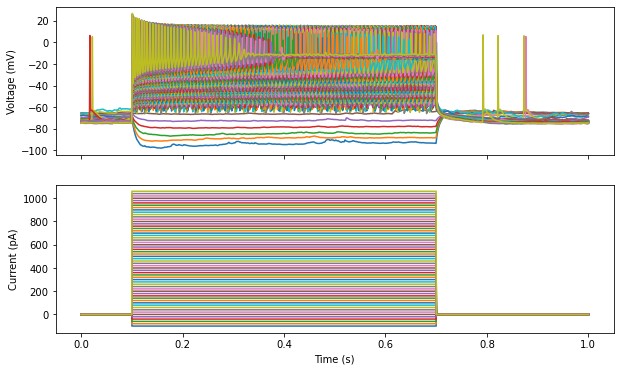

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes[0].plot(t_set.T, u_set.T)
axes[0].set_ylabel("Voltage (mV)")
axes[1].plot(t_set.T, i_set.T)
axes[1].set_ylabel("Current (pA)")
axes[1].set_xlabel("Time (s)")
plt.show()

# `EphysPy`

### Using `EphysSweep` and `EphysSweepSet` to compute electrophysiological features for the data

The fundametal objects that this toolbox operates on a are `EphysSweep`s and `EphysSweepSet`s, which are wrapped versions of the AllenSDKs `EphysSweepExtractor` and `EphysSweepSetExtractor` classes to provide additional functionality and a more intuitive interface.

These can be created from the above data as follows:

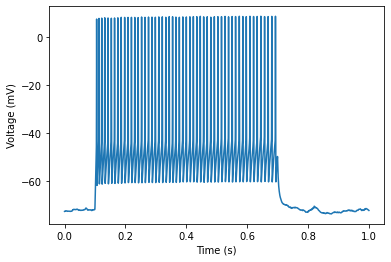

In [5]:
# create sweep
example_sweep = EphysSweep(
    t_set[13], u_set[13], i_set[13], filter=1, metadata={"dc_offset": dc_offset}
)

# the `.plot()` method enables quick visualization of the data
example_sweep.plot()
plt.show()

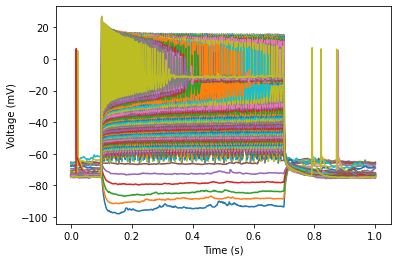

In [6]:
# create sweepset
example_sweepset = EphysSweepSet(
    t_set,
    u_set,
    i_set,
    filter=5,
    metadata={"dc_offset": dc_offset},
)

# ... which also comes with its own `.plot()` method
example_sweepset.plot()
plt.show()

The `metadata` attribute of the sweepset can be used to supply any kind of additional information about sweeps or the sweepset as a whole that can be accessed later (e.g. for plotting or setting hyperparameters for feature calculation).

In [7]:
# since the sweepset is just a collection of sweeps, `EphysSweepSet` allows to access
# individual sweeps by indexing
example_sweep = example_sweepset[13]

These objects can already be used to calculate features on the single spike level (e.g. spike amplitude, spike width, etc.) by calling the `process_spikes` spikes method. which is mostly standard AllenSDK functionality.

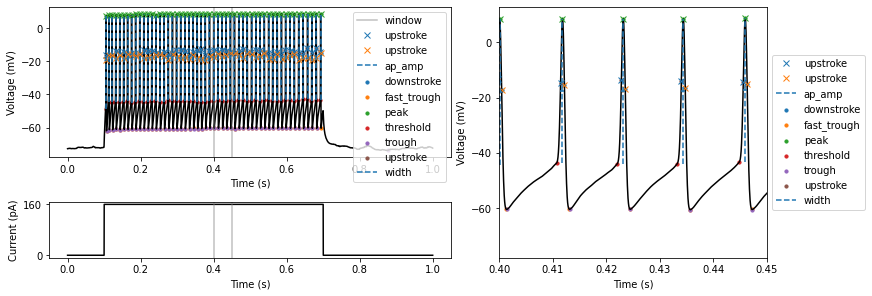

In [8]:
example_sweep.process_spikes()

# The resulting spike features are stored in the `_spikes_df` attribute of the sweep
# and can be quickly plotted using the `plot_spike_features` from `ephyspy.analysis`
plot_spike_features(example_sweep)
plt.show()

Every feature that can be computed in `EphysPy` is defined as a self-contained class, which inherit from `SpikeFeature`, `SweepFeature` or `SweepSetFeature`.
They can be found in the `ephyspy.features.base` module.

This allows to handle features very flexibly and intuitively, by simply instantiating a feature object, e.g.:

In [9]:
num_ap = Sweep_Num_AP(example_sweep)
print(num_ap)

num_ap = 53.000 /.'


If not otherwise specified the feature is computed automatically at initialization however, this can be disabled as well if you just want to instantiate it for later use.
If the feature has already been computed, it will not be recomputed unless explicitly requested and the cached value will be returned instead. This speeds up computation if the feature is reused during computation of other features.

In [10]:
timeit(lambda: num_ap.get_value(recompute=True), "time to compute num_ap")()
timeit(num_ap.get_value, "time to lookup num_ap")()

time to compute num_ap: 0.0155 s
time to lookup num_ap: 0.0000 s


Every feature is defined via its `_compute` method, that returns a feature's value and which can make use of everyhting that is available in the sweep object, i.e. the time, voltage and current arrays, as well as the metadata or even other features. This allows to easily define new features or modify existing ones, just by changing the `_compute` method. Furthermore, other features can be looked up during computation in a recursive manner, i.e. if a feature depends on another feature, the latter will be computed automatically if it is not already available. This enables every feature to be computed on its own and at any time, without having to worry about the order of computation. For details see definitions of `ephys.features.sweep_features` for example.

The most important attributes of a feature can be accessed as follows:

In [11]:
# A feature's value can be accessed via its `value` attribute
print(num_ap.value)

# along with its value intermediate results of a feature's computation can also be
# stored and accesed via the `diagnostics` attribute.
print(num_ap.diagnostics)

53
{'peak_i': array([ 2636,  2830,  3054,  3303,  3572,  3844,  4108,  4380,  4656,
        4938,  5215,  5494,  5768,  6046,  6329,  6606,  6897,  7181,
        7458,  7743,  8030,  8316,  8600,  8874,  9147,  9429,  9716,
       10003, 10296, 10580, 10860, 11149, 11427, 11720, 12012, 12303,
       12597, 12892, 13182, 13471, 13764, 14047, 14354, 14644, 14928,
       15229, 15526, 15822, 16125, 16430, 16723, 17024, 17324]), 'peak_t': array([0.10544, 0.1132 , 0.12216, 0.13212, 0.14288, 0.15376, 0.16432,
       0.1752 , 0.18624, 0.19752, 0.2086 , 0.21976, 0.23072, 0.24184,
       0.25316, 0.26424, 0.27588, 0.28724, 0.29832, 0.30972, 0.3212 ,
       0.33264, 0.344  , 0.35496, 0.36588, 0.37716, 0.38864, 0.40012,
       0.41184, 0.4232 , 0.4344 , 0.44596, 0.45708, 0.4688 , 0.48048,
       0.49212, 0.50388, 0.51568, 0.52728, 0.53884, 0.55056, 0.56188,
       0.57416, 0.58576, 0.59712, 0.60916, 0.62104, 0.63288, 0.645  ,
       0.6572 , 0.66892, 0.68096, 0.69296]), 'peak_v': array([7.6040753

The `diagnostics` attribute helps with debugging and understanding how a feature is computed. Intermediate results that arise duing computation of a feature or any metric that might be important to determine the quality of a feature can be store there. The ability to debug or quickly check on how a feature was computed is further aided by the addition of a `plot` method, which can added to every feature and be used to visualize a feature's value and diagnostics.

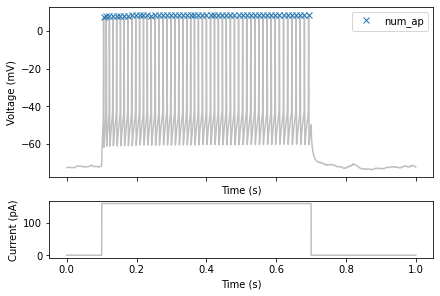

In [12]:
num_ap.plot(show_sweep=True, show_stimulus=True)
plt.show()

`EphysPy` already comes with a large number of features that can be used out of the box. These can be found in the `ephyspy.features` module and can also be listed as follows:

In [13]:
print("Available spike features:", list(available_spike_features().keys()))
print("Available sweep features:", list(available_sweep_features().keys()))
print("Available sweepset features:", list(available_sweepset_features().keys()))

Available spike features: ['ap_adp', 'ap_ahp', 'ap_udr', 'ap_amp', 'ap_downstroke', 'ap_fast_trough', 'ap_peak', 'ap_slow_trough', 'ap_thresh', 'ap_trough', 'ap_upstroke', 'ap_width', 'isi']
Available sweep features: ['ap_adp', 'ap_ahp', 'ap_cv', 'ap_ff', 'ap_udr', 'ap_amp', 'ap_amp_adapt', 'ap_amp_adapt_avg', 'ap_amp_slope', 'ap_freq', 'ap_freq_adapt', 'ap_latency', 'ap_peak', 'ap_thresh', 'ap_trough', 'ap_width', 'burstiness', 'isi', 'isi_cv', 'isi_ff', 'isi_adapt', 'isi_adapt_avg', 'num_ap', 'num_bursts', 'r_input', 'rebound', 'rebound_aps', 'rebound_area', 'rebound_avg', 'rebound_latency', 'sag', 'sag_area', 'sag_fraction', 'sag_ratio', 'sag_time', 'stim_amp', 'stim_end', 'stim_onset', 'tau', 'v_baseline', 'v_deflect', 'v_plateau', 'v_rest', 'v_sag', 'v_steady', 'wildness']
Available sweepset features: ['ap_adp', 'ap_ahp', 'ap_cv', 'ap_ff', 'ap_udr', 'ap_amp', 'ap_amp_adapt', 'ap_amp_adapt_avg', 'ap_amp_slope', 'ap_freq', 'ap_freq_adapt', 'ap_latency', 'ap_peak', 'ap_thresh', 'ap_t

In [14]:
# and computed via `get_feature`:
print("Num_AP:", get_feature("num_ap", example_sweep))

Num_AP: num_ap = 53.000 /.'


A different and perhaps more convenient way to interface with features is via the `add_features` method of `EphysSweep` and `EphysSweepSet`, which allows to add multiple features at once, either by name or by passing a list of feature objects.

In [15]:
# features can be added via the `add_features` method
example_sweep.add_features(available_spike_features())
example_sweep.add_features(available_sweep_features())

# and are stored in the `features` attribute
print("Spike features:", example_sweep.features)

Spike features: {'num_ap': num_ap for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'stim_onset': stim_onset for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'stim_end': stim_end for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_adp': ap_adp for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_ahp': ap_ahp for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_cv': ap_cv for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_ff': ap_ff for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_udr': ap_udr for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_amp': ap_amp for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_amp_adapt': ap_amp_adapt for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_amp_adapt_avg': ap_amp_adapt_avg for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_amp_slope': ap_amp_slope for <ephyspy.sweeps.EphysSweep object at 0x7ff47837e460>, 'ap_freq': ap_freq for <ephyspy

So far we have just added the features, but they have not yet been computed. We can do this either individually or all at once.

In [16]:
# any single feature can be accessed by just calling its value
# if the feature has not been computed yet, it will be computed
print("Number of spikes:", example_sweep.features["num_ap"].value)

# computing all features at once can be done via the `get_features` method
sweep_features = example_sweep.get_features()
print("Sweep features:", sweep_features)

Number of spikes: 53
Sweep features: {'num_ap': 53, 'stim_onset': 0.10003999999999998, 'stim_end': 0.7, 'ap_adp': nan, 'ap_ahp': -16.687004841164267, 'ap_cv': 0.011883420429187254, 'ap_ff': 0.007402170389396776, 'ap_udr': 0.8329492365104244, 'ap_amp': 52.37854949340192, 'ap_amp_adapt': 0.9370053926841857, 'ap_amp_adapt_avg': 0.9987194594588579, 'ap_amp_slope': 1.2669896049484088, 'ap_freq': 88.33922261484099, 'ap_freq_adapt': 0.9629629629629629, 'ap_latency': 0.004240000000000008, 'ap_peak': 8.5308712381146, 'ap_thresh': -43.900987193047115, 'ap_trough': -60.57095916316339, 'ap_width': 0.0010000000000000009, 'burstiness': nan, 'isi': 0.011360000000000037, 'isi_cv': 0.06489159787251618, 'isi_ff': 4.758339006126631e-05, 'isi_adapt': 1.1538461538461546, 'isi_adapt_avg': 1.0092691310705475, 'num_bursts': nan, 'r_input': nan, 'rebound': nan, 'rebound_aps': nan, 'rebound_area': nan, 'rebound_avg': nan, 'rebound_latency': nan, 'sag': nan, 'sag_area': nan, 'sag_fraction': nan, 'sag_ratio': nan

This workflow does not just apply to sweeps but can also be used for sweepsets. 

Again features can be added via the `add_features` method and computed as follows.

In [17]:
# add features to sweepset
example_sweepset.add_features(available_spike_features())
example_sweepset.add_features(available_sweepset_features())

# and again they are stored in the `features` attribute
print("Spike features:", example_sweepset.features)

# again any single feature can be accessed by just calling its value
print("Number of spikes:", example_sweepset.features["num_ap"].value)

# computing all features at once can be done via the `get_features` method
sweepset_features = example_sweepset.get_features()
print("Sweepset features:", sweepset_features)

Spike features: {'ap_adp': ap_adp for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_ahp': ap_ahp for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_cv': ap_cv for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_ff': ap_ff for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_udr': ap_udr for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_amp': ap_amp for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_amp_adapt': ap_amp_adapt for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_amp_adapt_avg': ap_amp_adapt_avg for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_amp_slope': ap_amp_slope for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_freq': ap_freq for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_freq_adapt': ap_freq_adapt for <ephyspy.sweeps.EphysSweepSet object at 0x7ff4746c2f40>, 'ap_latency': ap_latency for <ephyspy.sweeps.EphysSweepSet object at 

### Analysis of the extracted feature information

Along with the abilty to compute and plot every feature on the individual level `ephyspy` also provides several higher level plotting functions that can be used to derive insights from the data. For example, `plot_sweepset_diagnostics` can be used to better trace how features were computed across a sweepset.

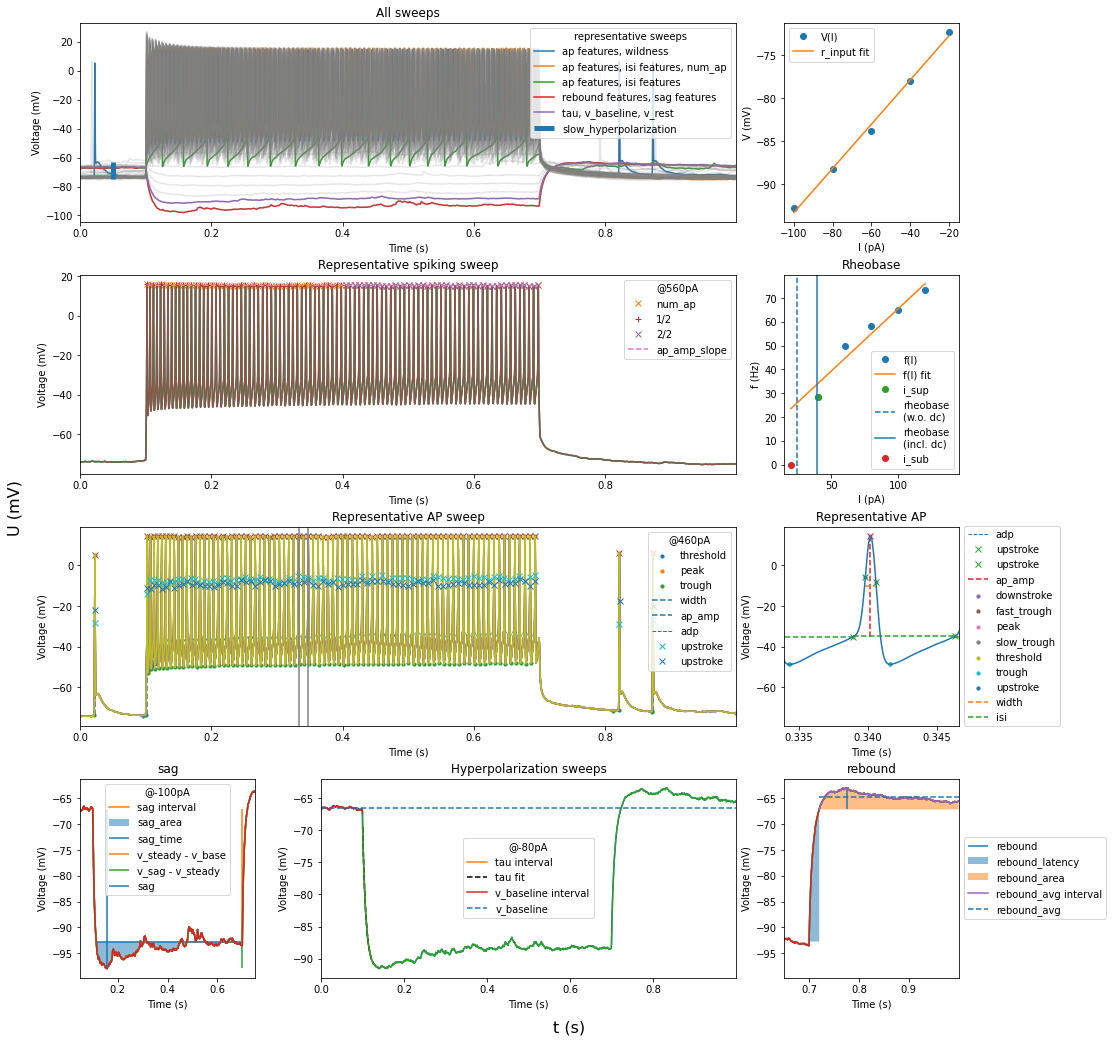

In [18]:
plot_sweepset_diagnostics(example_sweepset)
plt.show()

### Adding custom features to `ephyspy`

To add custom features to the `ephyspy` ecosystem, they can be registered via the `register_custom_feature` function, which takes a feature class as input and stores it in the `ephyspy.features` module. This allows to access the feature via its name and to use it in the same way as any other feature, i.e. make use of recursive computation, caching, etc. Features should inherit from `BaseFeature`. In the case of spike, sweep, or sweepset features they should inherit from `SpikeFeature`, `SweepFeature`, or `SweepSetFeature`, respectively.

In [19]:
# For more info see the package's documentation
print(register_custom_feature.__doc__, "\n")

Add a custom feature class that inherits from `SweepFeature`
    or from `SweepSetFeature`. This makes the feature available to all the
    the EphysPy functionalities such as recursive computation of all dependend
    features that are called with `lookup_X_feature`, where X can be spike,
    sweep or sweepset.

    Args:
        Feature: Feature class to be added to EphysPy ecosystem. Feature
            must inherit from either `SweepFeature` or `SweesetFeature`.
     



##### BaseFeature class Documentation

In [20]:
print(BaseFeature.__doc__)

Base class for all electrophysiological features.

    This class defines the interface for all electrophysiological features.
    All sweep features should inherit from this class, and must implement a
    `_compute` and `_data_init` method. The `_compute` method should return the
    feature value and optionally save diagnostic information for later debugging to
    `self._diagnostics`. The `_data_init` method should be used to set the
    `self.data` attribute, and add the feature to the `self.data.features`.

    The description of the feature should contain a short description of the
    feature, and a list of dependencies. The dependencies should be listed
    as a comma separated list of feature names. It is parsed and can be displayed
    but has no functional use for now. Furthermore, the units of the feature
    should be specified. If the feature is unitless, the units should be set to "/".

    The docstring should have the following format:

    '''<Some Text>

    descrip